# Interactive tutorial: *extracting and sorting neural spikes*

***Disclosure***: this notebook is inspired from the following tutorial:
https://github.com/akcarsten/spike_sorting

Last week, we looked at how neural spikes influence the extracelular space, how they can be picked up by extracellular electrodes, and the challenges of discriminating spikes across different units (i.e., neurons) and from noise.

Today, we will look at signal processing methods to extract and classify spikes from such electrical recordings. 

To this aim, we will use as our dataset a 30 min long recording from a single electrode implanted in an epilepsy patient. The dataset is freely accessible at: 

https://leicester.figshare.com/articles/dataset/Dataset_Human_single-cell_recording/11302427/1

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from constants import *
from sigutils import *

## Step 1: Load the data

Let's start by loading the data

In [4]:
# Define data path
data_file = './data/CSC4.Ncs'
# Load data
data = load_ncs_data(data_file)
# Compute sampling frequency
fs = int(1 / np.diff(data[TIME_S])[0])

 14/02/2022 18:15:59: loading data from "./data/CSC4.Ncs"...
 14/02/2022 18:15:59: sampling rate = 32.05 kHz
 14/02/2022 18:15:59: dataset is 00:31:43.22 s (61000192 samples) long


Let's plot a chunk of signal to see what it looks like

 14/02/2022 18:16:01: plotting signals...


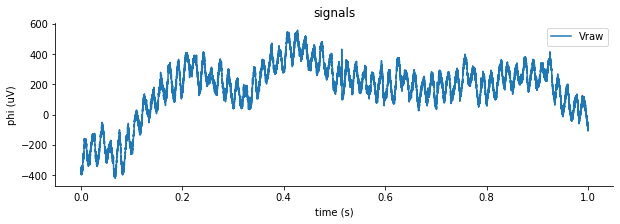

In [5]:
# Plot signal within defined time window
tbounds = [0., 1.]  # s
fig = plot_signals(data, tbounds=tbounds)

### Questions:
- *At first glance, what can you say about this recording?*
- *Do you see any obvious spikes?* 

To get a better idea of the different components at play in the signal, let's plot its frequency spectrum

 14/02/2022 18:16:02: extracting and plotting Vraw frequency sectrum...


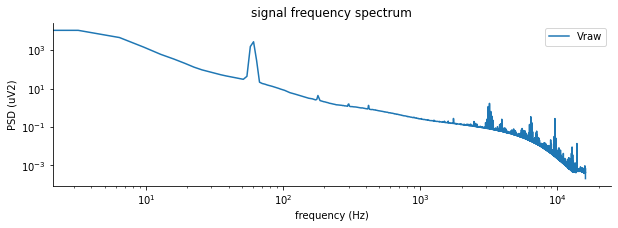

In [6]:
fig = plot_frequency_spectrum(data, fs)

### Questions:

- *What can you say about the different frequency components of the recording?* 
- *In light of what you know about action potential dynamics, what is our frequency range of interest?*

## Step 2: denoise the data

As we've seen in the previous sessions, action potentials are typically 1-2 ms long, which corresponds a "fundamental" frequency of 0.5-1 kHz. Moreover, spikes are highly nonlinear in nature, their natual frequency spectrum extends to a few kHz. Hence, our typical frequency range of interest for spikes detection is about [300 Hz - 6 kHz] (see https://pubmed.ncbi.nlm.nih.gov/15228749/ for reference).

By visually inspecting the frequency spectrum of the raw recording, we notice the presence of two significant sources of noise outside of our range of interest:
- a **low-frequency noise** with a peak at 60 Hz (seen as oscillations on the recording timeseries). This noise source is larger than the amplitude of a typical extracellular neural spike (10 to 100 uV) and will therefore preclude any robust spike detection.
- a **high-frequency noise** around 6-15 kHz (i.e. approaching our sampling frequency) that can be attributed to "sampling noise". That noise is smaller in amplitude and will therefore probably not preclude spike detection, but it will pollute the shape of resulting spikes.

Hence, in order to better detect our spikes, we will apply a band-pass filter that filters out these 2 frequency ranges.

 14/02/2022 18:16:08: band-pass filtering signal (cutoff = [ 300. 6000.] Hz)...
 14/02/2022 18:16:10: plotting signals...
 14/02/2022 18:16:12: extracting and plotting Vraw frequency sectrum...
 14/02/2022 18:16:17: extracting and plotting Vfilt frequency sectrum...


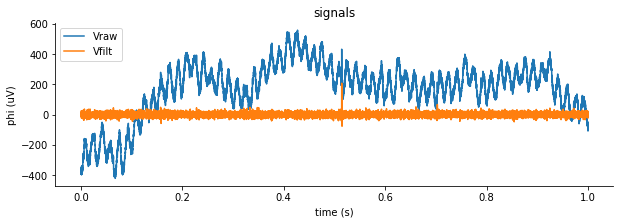

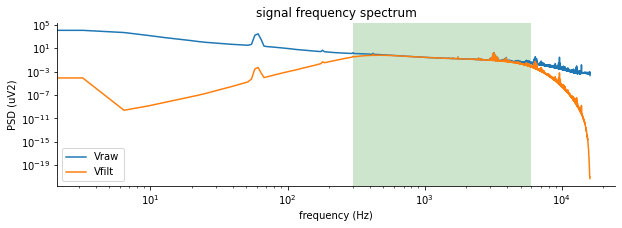

In [7]:
# Apply band-pass filter
fbounds = [300., 6000]  # Hz
data['Vfilt'] = filter_signal(data['Vraw'], fs, fbounds)

# Plot signals within defined time window
fig = plot_signals(data, tbounds=tbounds)
# Plot frequency spectra
fig2 = plot_frequency_spectrum(data, fs, band=fbounds)

### Questions:

- *What can you say about the effect of the filter onf the signal?*
- *What about its effect on the signal frequency spectrum?*
- *Do you see any obvious spikes on the filtered signal?*

## Extract spikes from the filtered signal

Now that we have a clean spike channel we can identify and extract spikes. We do so by:
- computing an absolute detection threshold from the filtered signal properties
- detecting peaks in the filtered signal that are above the fixed threshold
- extracting each candidate spike a signal window around its peak
 
Note that the polarity of the recording is such that extracellular spikes appear as *positive* voltage peaks, which is the opposite of their extracellular polarity.

 14/02/2022 18:18:59: detecting peaks in signal above 48.34 uV threshold...
 14/02/2022 18:18:59: extracting spikes from [-38  57] samples window around each peak...
 14/02/2022 18:18:59: 17151 spikes detected
 14/02/2022 18:18:59: plotting 17151 spike traces...


100%|██████████| 17151/17151 [00:10<00:00, 1654.22it/s]


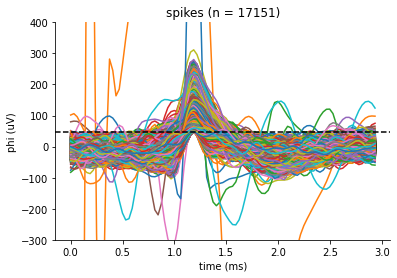

In [10]:
# Calculate absolute threshold based on signal mean
thr_factor = 5.  # relative threshold
Vthr = np.mean(np.abs(data['Vfilt'])) * thr_factor

# Detect peaks and extract spikes around peaks
wspike = 3e-3  # spike window length (s)
ispikes, spikes = get_spikes(data['Vfilt'].values, Vthr, wlen=wspike * fs)

# Plot detected spikes
fig = plot_spikes(spikes, fs, thr=Vthr)

As we can see, out algorithm did a good job at detecting physiological spikes, but it also detected a few aetifactual spikes of aberrant amplitude along the way.

Thankfully, we can easily get rid of these artifactual spikes using a simple amplitude filtering:   

 14/02/2022 18:21:16: discarding spikes outside of {Vbounds} interval...
 14/02/2022 18:21:16: filtered out 6 spikes
 14/02/2022 18:21:16: plotting 17145 spike traces...


100%|██████████| 17145/17145 [00:12<00:00, 1357.31it/s]


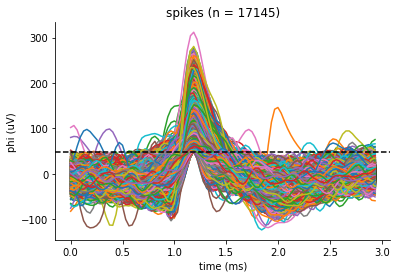

In [12]:
Vbounds = (-180., 350.)
ispikes, spikes = filter_spikes(ispikes, spikes, Vbounds)
fig = plot_spikes(spikes, fs, thr=Vthr)

Much better! We now see only spikes that appear to be of physiological origin. Moreover, their amplitude seem to vary quite a lot, which might indicate the presence of multiple spiking units (i.e., neurons).

To get a better idea of the data spikes population, we will plot a subset of 100 randomly selected spikes: 

 14/02/2022 18:24:14: plotting 100 randomly selected spike traces...


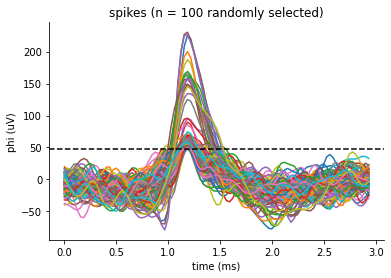

In [13]:
fig = plot_spikes(spikes, fs, thr=Vthr, n=100)

### Questions:

- *Based on the above observation, what can you say about the spike waveform distribution?*
- *How many spiking units do you think there are? Could they be differentiated?* 

## Reducing the number of dimensions with PCA

In order to classify our spikes we need some features to work with. These features could be arbitrarily extracted form the spikes waveforms, e.g. by chosing the peak amplitude of the spike or the width of the waveform.

A more principled way to extract such features is to use ***Principal Component Analysis (PCA)***. PCA is a dimensionality reduction technique commonly used in neuroscience (and machine learning to a greater extent), when we wish to classify observations that are high-dimensional in nature (such as events in a detailed timeseries). Simply put, PCA projects each data observation (in our case, spike) on to a lower-dimensional subspace that captures *most of the variance* seen across the different observations (i.e. spikes). The dimensions of this subpace (so-called *principal components*) represent linear combinations (or *features*) of the original observations.

Despite its apparent complexity, this algorithm only consists of a few linear algebra transformations (which we will not detail here).

### Questions:
- *In our case, what is a principal component made of?*
- *What will a particular point in the PC space correspond to?*



Let's apply PCA on our spike dataset, and plot the projection of each spike on to the first 3 principle components:

 14/02/2022 18:40:35: applying PCA on (17145, 95) dataset...
 14/02/2022 18:40:36: plotting distribution of first principal components...


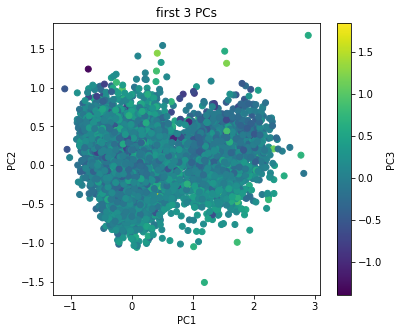

In [15]:
PCs_per_spike = apply_pca(spikes)
fig = plot_principal_components(PCs_per_spike)

### Questions:

- *What can you say about the distribution of the spike population in the PC space?*
- *Do you see diffferent clusters emerging?*

## Clustering with k-means

Now that we projected our spikes dataset onto a low-dimensional subspace, we can try to classify the spikes, i.e. *assign each spike occurence to a particular spiking unit*.

To this aim, we will use a simple *k-means* clustering algorihm (also a classic in the fields of neuroscience and machine learning). Simply put, *k-means* tries to...



First, we choose a number of K random datapoints from our sample. These datapoints represent the cluster centers and their number equals the number of clusters.

Next, we will calculate the Euclidean distance between all of the random cluster centers and any other datapoint.

Then we assign each datapoint to the cluster center closest to it.

Obviously doing all of this with random datapoints will not give us a good clustering result. So, we start over again. But this time we don't use random datapoints as cluster centers. Instead we calculate the actual cluster centers based on the previous random assignments and start the process again… and again… and again.

With every iteration the datapoints that switch clusters will go down and we will arrive at a (hopefully) global optimum.

 14/02/2022 18:40:59: applying k-means clustering with 2 clusters...
 14/02/2022 18:40:59: plotting distribution of first principal components...
 14/02/2022 18:40:59: plotting average spike traces for 2 clusters...
 14/02/2022 18:40:59: applying k-means clustering with 3 clusters...
 14/02/2022 18:41:00: plotting distribution of first principal components...
 14/02/2022 18:41:00: plotting average spike traces for 3 clusters...
 14/02/2022 18:41:00: applying k-means clustering with 4 clusters...
 14/02/2022 18:41:01: plotting distribution of first principal components...
 14/02/2022 18:41:01: plotting average spike traces for 4 clusters...
 14/02/2022 18:41:01: applying k-means clustering with 5 clusters...
 14/02/2022 18:41:02: plotting distribution of first principal components...
 14/02/2022 18:41:02: plotting average spike traces for 5 clusters...
 14/02/2022 18:41:02: applying k-means clustering with 6 clusters...
 14/02/2022 18:41:03: plotting distribution of first principal comp

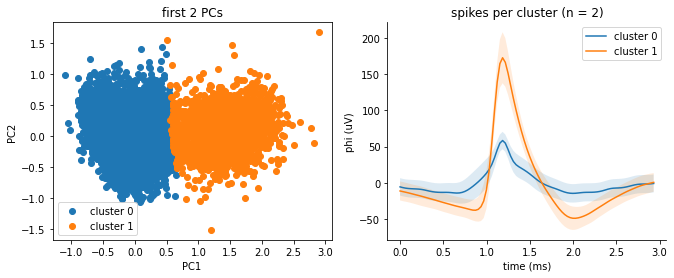

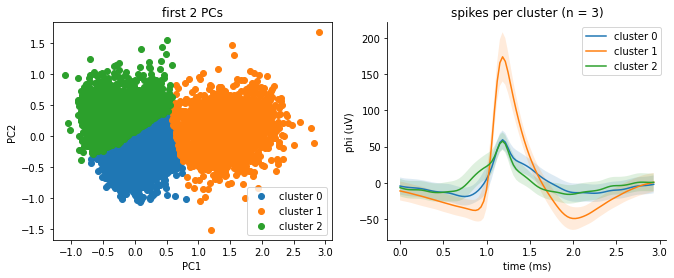

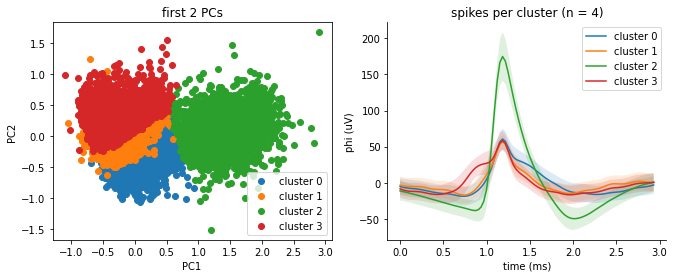

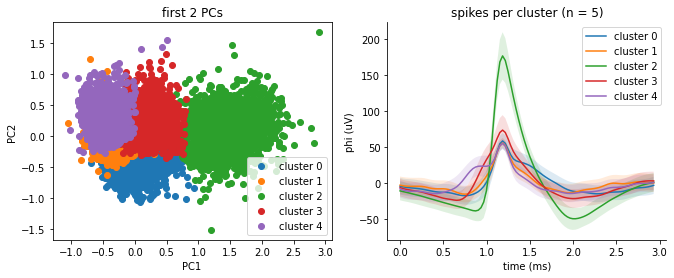

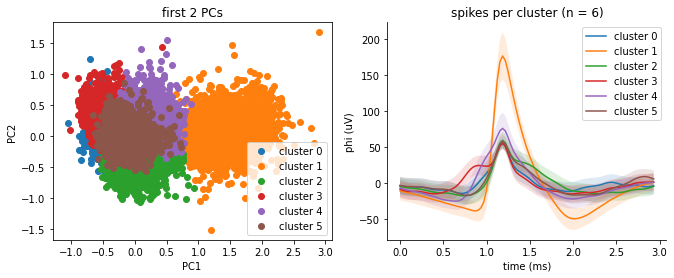

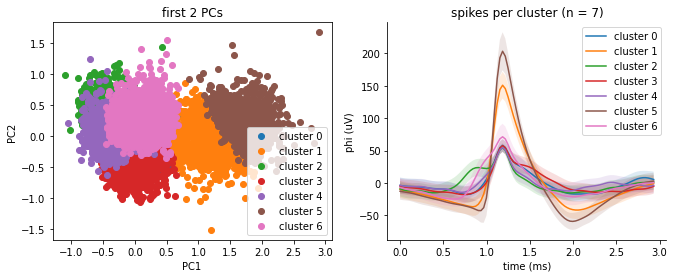

In [18]:
for n_clusters in range(2, 8):
    clusters = apply_kmeans(PCs_per_spike, n_clusters=n_clusters)
    fig = plot_PCs_and_spikes_per_cluster(PCs_per_spike, spikes, clusters, fs)